* [Constants](#Constants)
* [Load data](#Load-data)
* [Train Word2Vec](#Train-Word2Vec)
* [Prepare text](#Prepare-text)
* [Defining the neural network](#Defining-the-neural-network) 
* [Training the neural net](#Training-the-neural-net)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

from sklearn.model_selection import train_test_split
from os.path import isfile

from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, Conv1D, Dense, GlobalMaxPooling1D
from keras.optimizers import RMSprop
from keras.regularizers import l1

from gensim.models import word2vec
from gensim.models import KeyedVectors


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Constants

In [ ]:
# Location of train/test data files generated by TextSections/TextPrep
TRAIN_DATA_LOC = "~/train_data.csv"
TEST_DATA_LOC  = "~/test_data.csv"

# Columns we will use:
VISITID        = "visit_id"
OUTCOME        = "readmitted" # e.g. ReadmissionInLessThan30Days

# Test/Train split
SPLIT_SIZE = 0.9 # relative size of train:test
SPLIT_SEED = 1234

# Word2Vec hyperparameters
WINDOW        = 2
DIMENSIONS    = 1000
MIN_COUNT     = 5
USE_SKIPGRAM  = True  
USE_HIER_SMAX = False  
NUM_THREADS   = 50
# Where to save the w2v model:
W2V_FILENAME = './w2v_dims_{dims}_window_{window}.bin'.format(
    dims    = DIMENSIONS,
    window  = WINDOW
)


# Text Prep
PADDING       = "PADDING"
MAX_NOTE_LEN  = 700
MIN_NOTE_LEN  = 20

# Model Architecture
UNITS         = 450
FILTERSIZE    = 3
LEARNING_RATE = 0.0001
LOSS_FUNC     = 'binary_crossentropy'
REG_FACTOR    = 0.05

# Model Training
CNN_FILENAME = "./cnn.h5"
BATCH_SIZE   = 100
EPOCHS       = 4

# Load data

In [2]:
# Read train and test hospital data.
train = pd.read_csv(TRAIN_DATA_LOC, dtype = str)
test  = pd.read_csv(TEST_DATA_LOC,  dtype = str)

# Split the train data into a train and validation set.
train, valid = train_test_split(train, 
                                stratify     = train[OUTCOME], 
                                train_size   = SPLIT_SIZE, 
                                random_state = SPLIT_SEED)

# Prepare the sections.
# If `sectiontext` is present, then include "SECTIONNAME sectiontext".
# If not present, include only "SECTIONNAME".
SECTIONNAMES = [x for x in trainTXT.columns if VISITID not in x and OUTCOME not in x]
for x in SECTIONNAMES:
    rep      = x.replace(" ", "_").upper()
    train[x] = [" ".join([rep, t]) if not pd.isnull(t) else rep for t in train[x]]
    valid[x] = [" ".join([rep, t]) if not pd.isnull(t) else rep for t in valid[x]]
    test[x]  = [" ".join([rep, t]) if not pd.isnull(t) else rep for t in test[x]]

# Train Word2Vec

In [3]:
# We will remove digits and punctuation:
remove_digits_punc = str.maketrans('', '', string.digits + ''.join([x for x in string.punctuation if '_' not in x]))
remove_digits_punc = {a:" " for a in remove_digits_punc.keys()}

# (If the model already exists, don't recompute.)
if not isfile(W2V_FILENAME):
    # Use only training data to train word2vec:
    notes = train[SECTIONNAMES].apply(lambda x: " ".join(x), axis=1).values  
    stop  = set([x for x in string.ascii_lowercase]) 
    for i in range(len(notes)):
        notes[i] = [w for w in notes[i].translate(remove_digits_punc).split() if (w not in stop)]
    
    w2v = word2vec.Word2Vec(notes, 
                            size      = DIMENSIONS, 
                            window    = WINDOW, 
                            sg        = USE_SKIPGRAM, 
                            hs        = USE_HIER_SMAX, 
                            min_count = MIN_COUNT, 
                            workers   = NUM_THREADS)
    w2v.wv.save_word2vec_format(W2V_FILENAME, binary=True)
else:
    w2v = KeyedVectors.load_word2vec_format(W2V_FILENAME, binary=True)

2017-10-27 12:32:33,194 : INFO : loading projection weights from ./word2vec/w2v_dims_1000_window_2.bin
2017-10-27 12:32:33,507 : INFO : loaded (22330, 1000) matrix from ./word2vec/w2v_dims_1000_window_2.bin


In [4]:
# Make the embedding matrix.
# We include one extra word, `PADDING`. This is the word that will right-pad short notes.
# For `PADDING`'s vector representation, we choose the zero vector.
vocab = [PADDING] + sorted(list(w2v.wv.vocab.keys()))
vset  = set(vocab)

embeddings_index = {}
for i in range(len(vocab)):
    embeddings_index[vocab[i]] = i

# reverse_embeddings_index = {b:a for a,b in embeddings_index.items()}

# Adding PADDING as vocab word with embedding value of a zero vector
embeddings_matrix = np.matrix(np.concatenate(([[0.] * DIMENSIONS], [w2v[x] for x in vocab[1:]])))

# Prepare text

In [5]:
train_x = train[SECTIONNAMES].apply(lambda x: (" ".join(x)).translate(remove_digits_punc), axis=1).values  
test_x  = test[ SECTIONNAMES].apply(lambda x: (" ".join(x)).translate(remove_digits_punc), axis=1).values  
valid_x = valid[SECTIONNAMES].apply(lambda x: (" ".join(x)).translate(remove_digits_punc), axis=1).values  

train_x = [[embeddings_index[x] for x in note.split() if x in vset] for note in train_x]
valid_x = [[embeddings_index[x] for x in note.split() if x in vset] for note in valid_x]
test_x  = [[embeddings_index[x] for x in note.split() if x in vset] for note in test_x]

train_y = train[OUTCOME]
valid_y = valid[OUTCOME]
test_y  = test[OUTCOME]

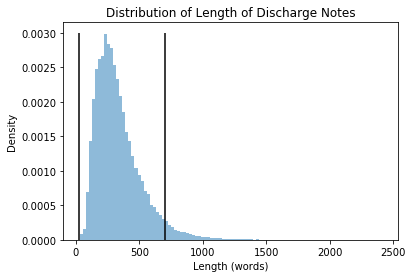

In [6]:
# We decide the max and min length (in words) of discharge notes.

plt.hist([len(x) for x in train_x], normed=1, bins=100, alpha=.5)
plt.vlines(MAX_NOTE_LEN, 0, .003); plt.vlines(MIN_NOTE_LEN, 0, .003);
plt.xlabel("Length (words)"); plt.ylabel("Density");
plt.title("Distribution of Length of Discharge Notes")
plt.show()

In [7]:
# Keep only the notes that are long enough:
subset_train = set(np.where([len(x) >= MIN_NOTE_LEN for x in train_x])[0])
subset_test  = set(np.where([len(x) >= MIN_NOTE_LEN for x in test_x])[0])
subset_valid = set(np.where([len(x) >= MIN_NOTE_LEN for x in valid_x])[0])

def getsubset(orig, index):
    return([j for i,j in enumerate(orig) if i in index])

# Pad the notes that are too short:
train_x = pad_sequences(getsubset(train_x, subset_train), maxlen=MAX_NOTE_LEN, padding='post', truncating='post')
valid_x = pad_sequences(getsubset(valid_x, subset_valid), maxlen=MAX_NOTE_LEN, padding='post', truncating='post')
test_x  = pad_sequences(getsubset(test_x,  subset_test),  maxlen=MAX_NOTE_LEN, padding='post', truncating='post')

train_y = np.array(getsubset(train_y, subset_train))
valid_y = np.array(getsubset(valid_y, subset_valid))
test_y  = np.array(getsubset(test_y,  subset_test))

# Defining the neural network

In [8]:
seq_input_layer = Input(shape=(MAX_NOTE_LEN,), dtype='int32')

embedded_layer  = Embedding(embeddings_matrix.shape[0], embeddings_matrix.shape[1],
                      weights      = [embeddings_matrix],
                      input_length = MAX_NOTE_LEN,
                      trainable    = True)(seq_input_layer)

conv_layer      = Conv1D(UNITS, FILTERSIZE, activation='tanh')(embedded_layer)

pool_layer      = GlobalMaxPooling1D()(conv_layer)

out_layer       = Dense(1, 
                        activation           = 'sigmoid', 
                        activity_regularizer = l1(REG_FACTOR)
                       )(pool_layer)

optimizer = RMSprop(lr = LEARNING_RATE)
model     = Model(inputs=seq_input_layer, outputs=out_layer)
model.compile(loss=LOSS_FUNC, optimizer=optimizer)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 700)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 700, 1000)         22331000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 698, 450)          1350450   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 450)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 451       
Total params: 23,681,901
Trainable params: 23,681,901
Non-trainable params: 0
_________________________________________________________________


# Training the neural net

In [10]:
# Load the weights from a previous run, or train the model anew:
if isfile(CNN_FILENAME):
    model.load_weights(CNN_FILENAME)
else:
    model.fit(train_x, train_y, 
              batch_size      = BATCH_SIZE, 
              epochs          = EPOCHS, 
              validation_data = (valid_x, valid_y), 
              verbose         = True)